# **Analyse de Paysage à partir de Données Lidar**

## Introduction

Ce notebook essaye d'analyser un paysage à partir d'un fichier de données Lidar issu de la plateforme IGN (https://diffusion-lidarhd.ign.fr/).  
L'objectif est de récupérer les données brutes, d'extraire les informations pertinentes et de calculer des indices pour caractériser le type de paysage.

### Objectifs :
1. **Importer les bibliothèques nécessaires** pour le traitement des données Lidar.
2. **Sélectionner et télécharger** un fichier de données Lidar à partir d'une URL spécifiée.
3. **Afficher les informations du fichier**, telles que les métadonnées et le format des points.
4. **Extraire les coordonnées et définir la taille d'un échantillon** pour l'analyse.
6. **Calculer des indices caractéristiques** par cellule du paysage à partir des données traitées.
7. **visualisation des résultat** Pour confronter nos résultat au donnée lidar brute.


# **Installation et import de librairie**
 **laspy** n'est pas natife sur google collab, lazrs sert de méthode de décompression

In [ ]:
!pip install laspy[lazrs,laszip] ## Ajout de laspy et package lazrs


# Import des bibliothèques nécessaires

In [ ]:
# Pour la récupération des fichiers
import requests

# Pour l'ouvertue la lecture des fichiers
import laspy
import lazrs

# Bibliothèques utile a l'exploitation des données
import pandas as pd
import numpy as np

# Bibliothèques utile à la visualisation des données
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy.ndimage import label,generic_filter  # Vérifier l'utilisation
from scipy.stats import mode                    # Vérifier l'utilisation
#from scipy.interpolate import griddata         # Vérifier l'utilisation

# Bibliothèques utile au calcul d'indicateur
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Utile à la création du zoning
from skimage.measure import find_contours

# Utile à la récupération des coordonées GPS
from pyproj import Transformer

# Utilise pour la projection de coordonée GPS sur un carte
import folium


In [ ]:
transformer = Transformer.from_crs("EPSG:2154", "EPSG:4326", always_xy=True)


# **Téléchargement et lecture du fichier**

In [ ]:
url = "https://storage.sbg.cloud.ovh.net/v1/AUTH_63234f509d6048bca3c9fd7928720ca1/ppk-lidar/QI/LHD_FXX_0938_6673_PTS_C_LAMB93_IGN69.copc.laz"  # @param {type: "string"}

nom_fichier = "data.laz"

# Télécharger le fichier
response = requests.get(url, stream=True)
with open(nom_fichier, "wb") as file:
    for chunk in response.iter_content(chunk_size=157286400):
        file.write(chunk)


# Specify the backend explicitly
las = laspy.read(nom_fichier)

# Affichage du header
print("=== Header du fichier ===")
print(las.header)

# Nombre de point (x)
print("\n=== Nombre de point (x) ===")
print(len(las.x))

# Afficher le format des points
print("\n=== Format des points ===")
print(las.point_format)

# Liste des noms des attributs
print("\n=== Dimensions disponibles dans les points ===")
for dim in las.point_format.dimension_names:
    print(dim)

=== Header du fichier ===
<LasHeader(1.4, <PointFormat(6, 0 bytes of extra dims)>)>

=== Nombre de point (x) ===
24296148

=== Format des points ===
<PointFormat(6, 0 bytes of extra dims)>

=== Dimensions disponibles dans les points ===
X
Y
Z
intensity
return_number
number_of_returns
synthetic
key_point
withheld
overlap
scanner_channel
scan_direction_flag
edge_of_flight_line
classification
user_data
scan_angle
point_source_id
gps_time


## Premier Visualisation du fichier

In [ ]:
# Détermination de l'étendue spatiale de la dalle
min_latitude, min_longitude = transformer.transform(las.x.min(),las.y.min())
max_latitude, max_longitude = transformer.transform(las.x.max(),las.y.max())

print(min_latitude, min_longitude)
print(max_latitude, max_longitude)



6.139101567381703 47.10567769662924
6.15280329971946 47.11431492544279


In [ ]:
map_center = [(min_longitude + max_longitude)/2, (min_latitude + max_latitude)/2]  # Paris en exemple
map = folium.Map(location=map_center, zoom_start=16)
kw = {
        "color": "blue",
        "line_cap": "round",
        "fill": True,
        "fill_color": "red",
        "weight": 3,
        #"tooltip": folium.Tooltip(tooltip_text),
    }
folium.Rectangle(bounds=[(min_longitude,min_latitude), ( max_longitude,max_latitude)],**kw).add_to(map)
map

# **Création du jeux de donnée a partir d'un échantillon**

In [ ]:
sample_size = 100000  #Taille de l'échantillion


# Générer des indices aléatoires sans remplacement
total_points = len(las.x)
indices = np.random.choice(total_points, size=sample_size, replace=False)

pourcentage = (sample_size / total_points) * 100

# Affichage du résultat
print(f"Taille de l'échantillon : {len(indices)}, soit {pourcentage:.3f}% des points")

Taille de l'échantillon : 100000, soit 0.412% des points


In [ ]:
# Récupération des donnée brute lidar a partir des de la taille d'échantillon définit

x = np.array(las.x[indices])
y = np.array(las.y[indices])
z = np.array(las.z[indices])
classification = np.array(las.classification[indices])
intensity = np.array(las.intensity[indices])
return_number = np.array(las.return_number[indices])


display_data = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z,
    'classification': classification,
    'intensity': intensity,
    'return_number': return_number
})

display_data.head()

,x,y,z,classification,intensity,return_number
0,938534.06,6672207.19,332.54,5,1224,1
1,938077.56,6672403.83,351.62,2,463,2
2,938187.66,6672056.38,330.26,2,1132,1
3,938762.01,6672675.91,396.44,3,192,2
4,938984.57,6672217.78,426.87,2,1177,1


# **Définitnion de la fonction de scoring**

Blabla a mettre ici

In [ ]:
def scorer_paysages(prop_batiments, prop_vegetation, range_sol, rugosite_sol,
                     mean_height, iqr_height, fragmentation_index,
                     building_to_ground_ratio, anisotropy_index,
                     pente_moyenne, indice_planeite, prop_ground, single_return_ratio,mean_intensity):
    """
    Calcule un score pour plusieurs types de paysage à partir des indicateurs suivants :
      - prop_batiments : proportion de points classés bâtiment (0 à 1)
      - prop_vegetation : proportion de points classés végétation (0 à 1)
      - range_sol : étendue d'altitude (m) sur les points de sol
      - rugosite_sol : écart-type des altitudes du sol (m)
      - mean_height : hauteur moyenne des points (m)
      - iqr_height : écart interquartile des hauteurs (m)
      - fragmentation_index : indice de fragmentation des classes
      - building_to_ground_ratio : rapport entre bâtiments et sol
      - anisotropy_index : indice de directionnalité des structures
      - pente_moyenne : pente moyenne du terrain (en degrés)
      - indice_planeite : écart-type des résidus par rapport à un plan ajusté (m)
      - prop_ground : proportion de points classés comme sol
      - single_return_ratio : proportion de points avec un seul retour
      - mean_intensity : intensité moyenne des points

    Retourne un dictionnaire avec les scores pour chaque type de paysage.
    """
    scores = {
        "Ville": 0,
        "Village / Banlieue": 0,
        "Champs": 0,
        "Forêt": 0,
        "Montagne": 0,
        "Eau": 0
    }

    # --- Score pour Ville ---
    if prop_batiments >= 0.1:
        score_ville = (500 * prop_batiments) + (50 * mean_height) + (50 * building_to_ground_ratio)
    else:
        score_ville = 0
    scores["Ville"] = score_ville

    # --- Score pour Village / Banlieue ---
    if prop_batiments >= 0.01:
        score_village = (400 * prop_batiments) + (30 * mean_height) + (25 * building_to_ground_ratio)
    else:
        score_village = 0
    scores["Village / Banlieue"] = score_village

    # --- Score pour Champs ---
    bonus_slope = max(0, 5 - pente_moyenne) * 5
    bonus_planarity = max(0, 10 - indice_planeite) * 2
    score_champs = (50 * (1 - prop_batiments)) + (50 * (1 - prop_vegetation)) + bonus_slope + bonus_planarity
    scores["Champs"] = score_champs

    # --- Score pour Forêt ---
    score_foret = (800 * prop_vegetation) + (50 * fragmentation_index) + (20 * iqr_height)
    scores["Forêt"] = score_foret

    # --- Score pour Montagne ---
    if range_sol >= 100 or pente_moyenne >= 8:
        score_montagne = (range_sol * 10) + (rugosite_sol * 10) + (pente_moyenne * 15) + (indice_planeite * 5)  + (30 * anisotropy_index) + (20 * iqr_height) - (1000 * prop_batiments)
    else:
        score_montagne = 0
    scores["Montagne"] = score_montagne


    return scores

# Découpage de la dale lidar, pour la récupération des données

## **Préparation de la grille**

- la dimension de la dalle est de 1Km².
- avec des carreaux de 25m² -> une grille de 40*40


In [ ]:

# Dimention d'une cellule par rapport a la grille
cell_size = 25

# Détermination de l'étendue spatiale de la dalle
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()



# Nombre de cellules en x et y
nx = int(np.ceil((x_max - x_min) / cell_size))
ny = int(np.ceil((y_max - y_min) / cell_size))

# Matrice pour stocker la classification de chaque cellule
grid_classification = np.empty((ny, nx), dtype=object)

# Matrice pour stocker la classification de chaque cellule
grid_score = np.empty((ny, nx), dtype=object)

## **Boucle sur les données lidar**

TODO --> Découper en 2 boucles
  - indicateur
  - calcul du score
  - Ajout de print a la premier itération de la boucle pour clarifié le suivit ?

In [ ]:
# Boucle sur chaque cellule de la grille
for i in range(ny):
    for j in range(nx):


        # Définition des bornes de la cellule
        cell_x_min = x_min + j * cell_size
        cell_x_max = cell_x_min + cell_size
        cell_y_min = y_min + i * cell_size
        cell_y_max = cell_y_min + cell_size

        # Sélection des points dans la cellule
        mask = (x >= cell_x_min) & (x < cell_x_max) & (y >= cell_y_min) & (y < cell_y_max)

        ########################
        # "mask" me permet de récupérer directer les points concerné par la celulle "étudier"
        # Il est de la longueur du nombre de point lidar dans cellule ( entre 10 & ~ 150 a détaillé je pense)
        ########################

        n_points = np.sum(mask)

        if n_points < 10:
            # Si trop peu de points, on ne traite pas la cellule
            grid_classification[i, j] = "Insuffisant"
            grid_score[i, j] = "Insuffisant"
            continue

        ########################
        # Début calcul des indicateurs
        ########################

        density = n_points / (cell_size * cell_size)
        prop_building = np.sum(classification[mask] == 6) / n_points
        prop_vegetation = np.sum(np.isin(classification[mask], [3, 4, 5])) / n_points
        prop_ground = np.sum(classification[mask] == 2) / n_points  # Densité des points au sol

        z_cell = z[mask]
        alt_range = z_cell.max() - z_cell.min()
        rugosity = np.std(z_cell)
        mean_height = np.mean(z_cell)  # Hauteur moyenne

        iqr_height = np.percentile(z_cell, 75) - np.percentile(z_cell, 25)  # Écart interquartile d’altitude

        unique_classes, counts = np.unique(classification[mask], return_counts=True)
        fragmentation_index = len(unique_classes) / n_points  # Indice de fragmentation

        if np.sum(classification[mask] == 2) > 0:
            building_to_ground_ratio = np.sum(classification[mask] == 6) / np.sum(classification[mask] == 2)  # Ratio Bâtiments/Sol
        else:
            building_to_ground_ratio = 0

        # Calcul de la pente moyenne via régression linéaire sur les points
        if n_points > 10:
            coords = np.vstack((x[mask], y[mask])).T
            reg = LinearRegression().fit(coords, z_cell)
            grad = np.sqrt(reg.coef_[0]**2 + reg.coef_[1]**2)
            slope = np.degrees(np.arctan(grad))
        else:
            slope = 0

        # Calcul de l'indice de planéité
        X = coords
        y_cell = z_cell
        # Ensure X and y_cell have the same number of samples
        min_samples = min(X.shape[0], y_cell.shape[0])
        X = X[:min_samples]
        y_cell = y_cell[:min_samples]
        reg_plane = LinearRegression().fit(X, y_cell)
        y_pred = reg_plane.predict(X)
        residus = y_cell - y_pred
        planarity = np.nanstd(residus)

        # Indice de directionnalité des structures via PCA
        if n_points > 10:
            pca = PCA(n_components=2)
            pca.fit(coords)
            anisotropy_index = pca.explained_variance_ratio_[0] / pca.explained_variance_ratio_[1]
        else:
            anisotropy_index = 1  # Valeur par défaut pour éviter les divisions par zéro

        # intensité de la cellule
        intensity_cell = intensity[mask]
        mean_intensity = np.mean(intensity_cell)

        # Absence de points multiples
        single_return_ratio = np.sum(return_number[mask] == 1) / n_points

        ########################
        # Fin calcul des indicateurs
        ########################

        # Calcul des scores pour la cellule
        scores = scorer_paysages(prop_building, prop_vegetation, alt_range, rugosity,
                                 mean_height, iqr_height, fragmentation_index,
                                 building_to_ground_ratio, anisotropy_index,
                                 slope, planarity, prop_ground,single_return_ratio,mean_intensity)

        cell_class = max(scores, key=scores.get)
        grid_classification[i, j] = cell_class
        grid_score[i, j] = scores



## **Visualisation de la grille**

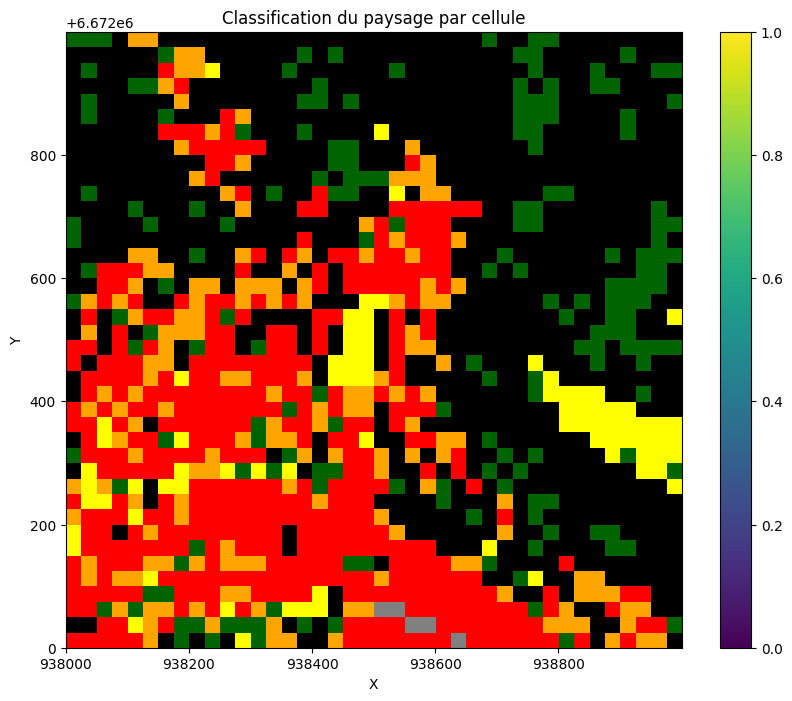

In [ ]:

# Visualisation de la grille
# On associe une couleur à chaque catégorie
color_map = {
    "Ville": "red",
    "Village / Banlieue": "orange",
    "Champs": "yellow",
    "Forêt": "darkgreen",
    "Montagne": "black",
    "Eau" :"blue",
    "Insuffisant": "gray"
}

# Créer une image couleur à partir de la grille de classification
grid_image = np.empty((ny, nx, 3))
for i in range(ny):
    for j in range(nx):
        # Convertir la couleur en RGB avec mcolors.to_rgb
        col = mcolors.to_rgb(color_map.get(grid_classification[i, j], "black"))
        grid_image[i, j, :] = col

plt.figure(figsize=(10, 8))
plt.imshow(grid_image, origin='lower', extent=(x_min, x_max, y_min, y_max))
plt.colorbar()
plt.title("Classification du paysage par cellule")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


# Définir une palette de couleurs pour quelques classes communes


# **Vrac fin visualisation en brouillon**

-> séparer & mettre au clair

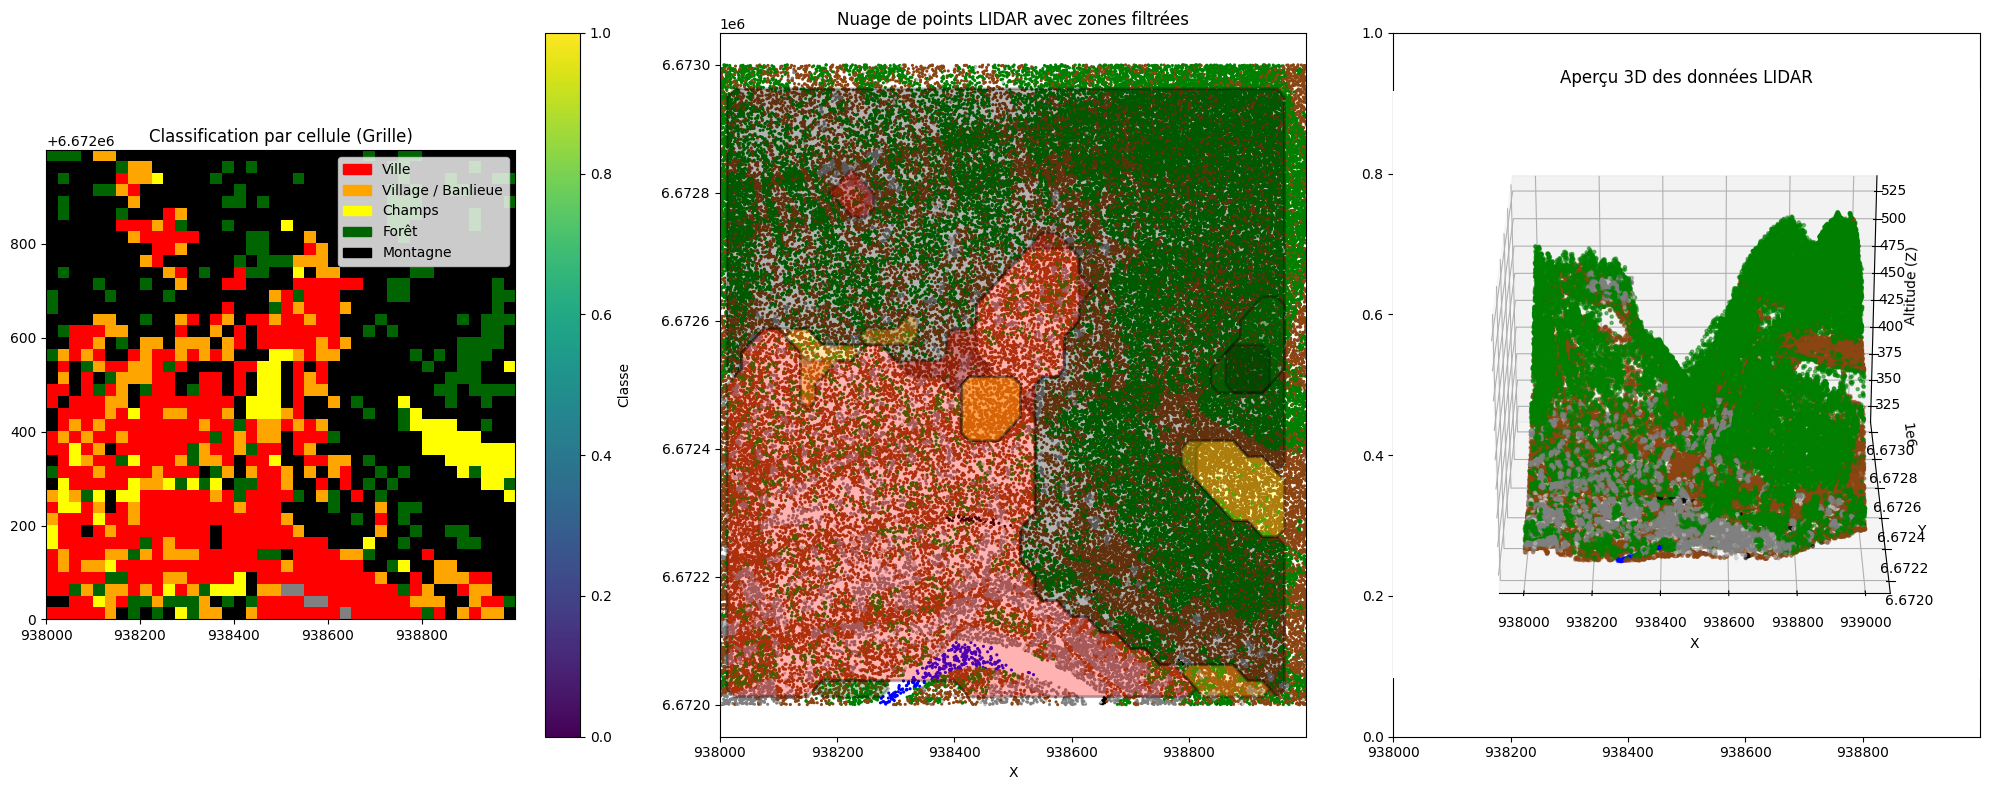

In [ ]:
import numpy as np
from scipy.stats import mode
from scipy.ndimage import generic_filter, label, binary_closing
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

########################
# 1. Fonctions utilitaires
########################

def majority_filter(arr):
    """Filtre de majorité (mode) appliqué à une fenêtre."""
    m = mode(arr, axis=None)
    return np.asarray(m.mode).flatten()[0]



########################
# list de couleur
########################
color_map = {
     0: 'black',       # Created, never classified
     1: 'silver',      # Unclassified
     2: 'saddlebrown', # Ground (sol)
     3: 'green',   # Low Vegetation (végétation basse)
     4: 'green',       # Medium Vegetation (végétation moyenne)
     5: 'green',   # High Vegetation (végétation haute)
     6: 'gray',        # Building (bâtiment)
     7: 'purple',      # Low Point (souvent du bruit ou points trop bas)
     8: 'orange',      # Model Key-point (points clés pour modélisation)
     9: 'blue',        # Water (eau)
     10: 'magenta',    # Reserved / Overlap Points (points en recouvrement)
     11: 'brown',      # Bridge Deck (pont, si utilisé)
     12: 'red'         # Autre code réservé (parfois utilisé pour du bruit élevé)
 }
 # Création d'une liste de couleurs pour chaque point
colors = [color_map.get(cl, 'black') for cl in classification]
zone_labels_text = {
    1: "Ville",
    2: "Village / Banlieue",
    3: "Champs",
    4: "Forêt",
    5: "Montagne",
}
zone_colors = {
    1: 'red',
    2: 'orange',
    3: 'yellow',
    4: 'darkgreen',
    5: 'black',
}

########################
# 2. Conversion en matrice numérique
########################

zone_map = {
    "Ville": 1,
    "Village / Banlieue": 2,
    "Champs": 3,
    "Forêt": 4,
    "Montagne": 5,
    "Eau": 6,
    "Insuffisant": 0
}

numeric_grid = np.vectorize(lambda cl: zone_map.get(cl, 0))(grid_classification)
ny, nx = numeric_grid.shape

########################
# 3. Lissage par filtre de majorité (fenêtre 5×5)
########################

smoothed_numeric_grid = generic_filter(numeric_grid, function=majority_filter, size=5)

########################
# 4. Extraction des zones via masques binaires
########################

zones_filtrees = []  # stocke (zone_type, region_mask, nb_cellules)
for zone in [1, 2, 3, 4, 5, 6]:
    mask = (smoothed_numeric_grid == zone)
    if not np.any(mask):
        continue

    # Fermeture morphologique pour fusionner les petites discontinuités
    closed_mask = binary_closing(mask, structure=np.ones((3, 3)))

    # Extraction des régions connectées
    labeled, num_features = label(closed_mask)
    for reg in range(1, num_features + 1):
        region_mask = (labeled == reg)
        nb_cellules = np.sum(region_mask)
        if nb_cellules >= 3:
            zones_filtrees.append((zone, region_mask, nb_cellules))

# Tri des zones par taille décroissante
zones_filtrees = sorted(zones_filtrees, key=lambda z: z[2], reverse=True)

# Limiter le nombre de zones affichées
zones_affichees = zones_filtrees[:10]

########################
# 5. Extraction des contours
########################

zone_polygons = []
for zone, region_mask, nb_cellules in zones_affichees:
    binary_region = region_mask.astype(float)
    contours = find_contours(binary_region, level=0.5)
    for contour in contours:
        xs = x_min + (contour[:, 1] / nx) * (x_max - x_min)
        ys = y_min + (contour[:, 0] / ny) * (y_max - y_min)
        zone_polygons.append((zone, np.column_stack((xs, ys))))

########################
# 6. Affichage côte à côte avec une troisième figure
########################

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharex=True)


# Panneau de gauche : Classification par cellule
im = ax1.imshow(grid_image, origin='lower', extent=(x_min, x_max, y_min, y_max))
ax1.set_title("Classification par cellule (Grille)")
# Légende
legend_patches = [
    mpatches.Patch(color=zone_colors[z], label=zone_labels_text[z])
    for z in sorted(zone_labels_text.keys())
]
ax1.legend(handles=legend_patches, loc='upper right')

fig.colorbar(im, ax=ax1, label="Classe")

# Panneau du milieu : Nuage de points LIDAR avec zones filtrées
ax2.scatter(x, y, c=colors,s=5, alpha=1, edgecolors='none', marker='o')
ax2.set_title("Nuage de points LIDAR avec zones filtrées")
ax2.set_xlabel("X")



# Superposer les polygones

for zone, poly in zone_polygons:
    patch = mpatches.Polygon(poly, closed=True, facecolor=zone_colors[zone],
                             edgecolor='black', alpha=0.3, lw=2)
    ax2.add_patch(patch)



########################
# 7. Troisième figure : Vue 3D des données LIDAR
########################

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(x, y, z, c=colors, s=5, alpha=0.5)

ax3.set_title("Aperçu 3D des données LIDAR")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Altitude (Z)")

# Ajuster la vue pour une meilleure perspective (optionnel)
ax3.view_init(elev=25, azim=270)  # Angle de vue ( en élévation 25° en 270 azimut pour la condorance)

plt.tight_layout()
plt.show()


# **Bonus, mappage interactif avec détail des scores**


In [ ]:
import plotly.graph_objects as go
import numpy as np



def format_scores(scores):

    if scores == 'Insuffisant':
        return "Aucune donnée"
    """Convertit les scores en pourcentages et les formate."""
    total = sum(scores.values())  # Somme totale des valeurs
    if total == 0:
        return "Aucune donnée"

    # Calcul des pourcentages
    percentages = {k: (v / total) * 100 for k, v in scores.items()}
    # Trier les pourcentages par ordre décroissant
    sorted_percentages = sorted(percentages.items(), key=lambda x: x[1], reverse=True)

    # Formater le texte avec les pourcentages triés
    text = "<br>".join([f"{k}: {v:.1f}%" for k, v in sorted_percentages if v > 0])
    return text


# Création des coordonnées et des valeurs
x_coords, y_coords, z_values, text_values = [], [], [], []

for i in range(ny):
    for j in range(nx):
        x_coords.append(j)
        y_coords.append(i)
        z_values.append(numeric_grid[i, j])  # Catégorie principale

        # Génération du texte des scores
        scores = grid_score[i, j]
        text_values.append(format_scores(grid_score[i, j]))

# Création du graphique interactif avec Plotly
fig = go.Figure(data=go.Heatmap(
    x=x_coords, y=y_coords, z=z_values,
    colorscale='Viridis',
    text=text_values,  # Texte des scores au survol
    hoverinfo="text"   # Affiche uniquement les infos des scores
))

# Personnalisation du layout
fig.update_layout(
    title="Classification du paysage avec détails interactifs",
    xaxis_title="X",
    yaxis_title="Y",
    xaxis=dict(scaleanchor="y"),
)

# Affichage
fig.show()